### Introduction to strong gravitational lensing

In a strong gravitational lens systems, light from a distant source is bent by the intervening mass of a galaxy, resulting in multiple images of the source.

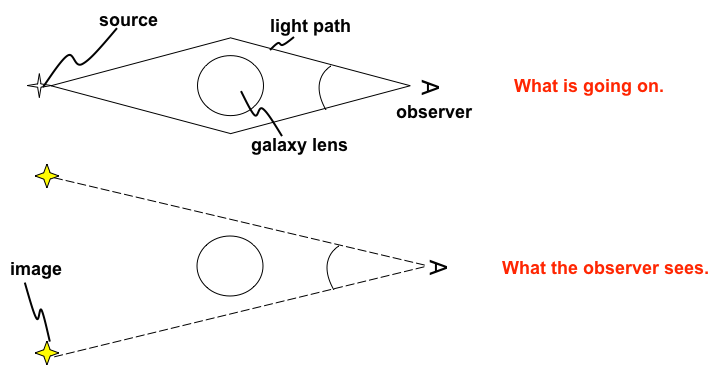

Here is an example of an observation of a strong lens.  The multiple images of a distant quasar are labeled A, B, C, and D, while the gravitational lens is labeled G1.

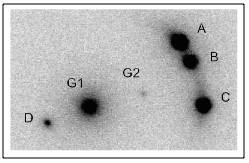

All the lensing effects are encapsulated in the lens equation:

$x_{source} = x_{image} - \alpha(x_{image})$,

where $x_{source}$ is the position of the source, $x_{image}$ is the position of an image and $\alpha(x_{image})$ is the deflection of the image due to gravitational lensing.  This equation may be multi-valued, making it difficult to solve for the image positions given the source position.  It is much easier to solve the equation by testing every possible image position and finding the corresponding source position. 

We grid the plane which describes all the possible image positions into triangles, then trace the triangles back to the plane of possible source positions.  We use triangles because no matter how you distort three points, they will always describe a triangle. A simple grid on the image plane can map onto a complicated pattern on the source plane.

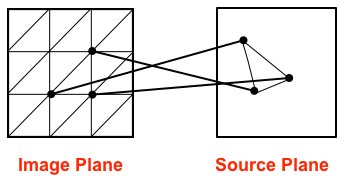

The triangles that intersect with the actual position of the source are the images.  A single point of light on the source plane can map onto a large area on the image plane and, thus, the image could exhibit large magnification.


In this notebook, we demonstrate a simple raytracing code which finds the images in a strong gravitional lensing system. Below is the guts of the raytracing code.  It takes a single array, x, which describes the mass distribution and position of the source as input.  It outputs an array with the image positions and magnifications.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
#import matplotlib
from scipy.interpolate import griddata
%matplotlib inline

In [6]:
def raytrace(x):

    # set up mesh for lens plane
    deltax=0.005
    x_grid=np.arange(-2.,2.,deltax)
    y_grid=np.arange(-2.,2.,deltax)
    xg,yg=np.meshgrid(x_grid,y_grid)

    # Lensmodel here (calculated for each grid point)

    bp=x[0]  
    q=x[1]
    gamma=x[2]
    theta_g=x[3]
    tx=x[4]
    ty=x[5]

    s=0.
    psi=np.sqrt(q**2.*(s**2.+xg**2.)+yg**2.)
    ydum=np.sqrt(1.-q**2.)*yg/(psi+q*q*s)
    xdum=np.sqrt(1.-q**2.)*xg/(psi+s)

    itanh=0.5*np.log((1.+ydum)/(1.-ydum))

    sie_phi_x=bp*q/np.sqrt(1.-q**2.)*np.arctan(np.sqrt(1.-q**2.)*xg/(psi+s))
    sie_phi_y=bp*q/np.sqrt(1.-q**2.)*itanh

    shear_phi_x=-gamma*(xg*np.cos(2.*theta_g)+yg*np.sin(2.*theta_g))
    shear_phi_y=-gamma*(-yg*np.cos(2*theta_g)+xg*np.sin(2.*theta_g))

    xs=xg-shear_phi_x-sie_phi_x
    ys=yg-shear_phi_y-sie_phi_y
    xst=xs-tx
    yst=ys-ty

    db1=np.sqrt(xst**2.+yst**2.)
    dc1=np.sqrt(xst**2.+yst**2.)
    dc2=np.sqrt(xst**2.+yst**2.)

    # Now need to find image positions
    # Need to go over all triangles

    delta=0.001
    mag=[]
    x_mod=[]
    mod_order=[]
    for i in range((len(x_grid)-1)/10):
        for j in range((len(y_grid)-1)/10):
            for k in range(2):
                if k == 0:
                    v1=(i*10,j*10)
                if k == 1:
                    v1=(i*10+10,j*10+10)

                v2=(i*10,j*10+10)
                v3=(i*10+10,j*10)

                dot1=xst[v1]*xst[v2]+yst[v1]*yst[v2]
                dot2=xst[v1]*xst[v3]+yst[v1]*yst[v3]
                dot3=xst[v3]*xst[v2]+yst[v3]*yst[v2]

                angle1=np.arccos(dot1/db1[v1]/dc1[v2])
                angle2=np.arccos(dot2/db1[v1]/dc2[v3])
                angle3=np.arccos(dot3/dc1[v2]/dc2[v3])

                tangle=(angle1)+(angle2)+(angle3)

            # If source position is inside source plane triangle, then reiterate    
                if tangle > 2.*np.pi-delta:
                    if tangle < 2.*np.pi+delta:

                         for ii in range(i*10,i*10+10):
                                for jj in range(j*10,j*10+10):
                                    for kk in range(2):
                                        if kk == 0:
                                            v1=(ii,jj)
                                        if kk == 1:
                                            v1=(ii+1,jj+1)

                                        v2=(ii,jj+1)
                                        v3=(ii+1,jj)

                                        dot1=xst[v1]*xst[v2]+yst[v1]*yst[v2]
                                        dot2=xst[v1]*xst[v3]+yst[v1]*yst[v3]
                                        dot3=xst[v3]*xst[v2]+yst[v3]*yst[v2]

                                        angle1=np.arccos(dot1/db1[v1]/dc1[v2])
                                        angle2=np.arccos(dot2/db1[v1]/dc2[v3])
                                        angle3=np.arccos(dot3/dc1[v2]/dc2[v3])

                                        tangle=(angle1)+(angle2)+(angle3)

                # If source position is inside source plane triangle, then good     
                                        if tangle > 2.*np.pi-delta:
                                            if tangle < 2.*np.pi+delta:

                                                da1=np.sqrt((xst[v1]-xst[v2])**2.+(yst[v1]-yst[v2])**2.)
                                                da2=np.sqrt((xst[v1]-xst[v3])**2.+(yst[v1]-yst[v3])**2.)
                                                da3=np.sqrt((xst[v2]-xst[v3])**2.+(yst[v2]-yst[v3])**2.)
                                                sourcearea=0.25*np.sqrt(2.*da2*da2*da3*da3+2.*da3*da3*da1*da1+2.*da1*da1*da2*da2-da1**4.-da2**4.-da3**4.)
                                                imarea=0.5*(deltax)**2.
                                                magnew=imarea/sourcearea
                # cut on highly demagnified images (ensure image number = 0,1,2,4)
                                                if magnew > 0.1:
                                                    mag.append(magnew)

                                                    td1=db1[v1]
                                                    td2=dc1[v2]
                                                    td3=dc2[v3]
                                                    if min(td1,td2,td3) == td1:
                                                        vclose=v1
                                                    elif min(td1,td2,td3) == td2:
                                                        vclose=v2
                                                    elif min(td1,td2,td3) == td3:
                                                        vclose=v3
                                                    x_mod.append(xg[vclose])
                                                    x_mod.append(yg[vclose])

    # raytracing is done

    x_mod = np.array(x_mod)
    x_mod = x_mod.reshape(len(mag),2)
    mag = np.array(mag)
    
    return mag,x_mod

Set an input, x, and run.  Then plot the results.

In [9]:
x = np.array([1, .7, .3, 1,.0,.0])
mod_mag,mod_x=raytrace(x)
print(mod_x)

[[ 0.875 -0.76 ]
 [-0.485 -0.44 ]
 [ 0.485  0.44 ]
 [-0.875  0.76 ]]


Text(-0.7,0.6,'(marker size is relative to magnification)')

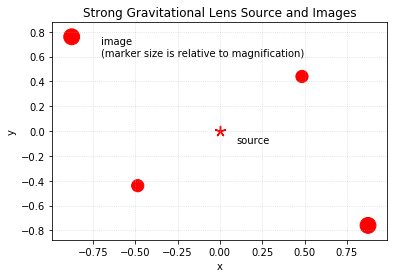

In [10]:
plt.figure()
plt.grid(True,linestyle='dotted',alpha=0.5)
plt.scatter(mod_x[:,0],mod_x[:,1],s=mod_mag*100,c='r')
plt.scatter(x[4],x[5],s=100, marker=(5, 2),c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Strong Gravitational Lens Source and Images')
plt.annotate('source',xy=(.01,.01),xytext=(.1,-.1))
plt.annotate('image',xy=(-.77,.835),xytext=(-.7,.7))
plt.annotate('(marker size is relative to magnification)',xy=(-.77,.835),xytext=(-.7,.6))

Let's investigate how the number, position, and magnification of images changes when we change the position of the source.  In the below routine, we test a range of source positions;  for each, we plot the source and resulting image positions in a single color.  

If you play with the values of the lens model and source position, you may notice that some inputs return errors.  This is because the lens equation can pass through singularities, where the magnification is formally infinity.  These sort of solutions have been observed in real life in "Einstein ring" systems.

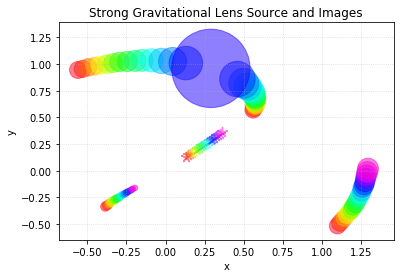

In [11]:
plt.figure()
plt.grid(True,linestyle='dotted',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Strong Gravitational Lens Source and Images')
x = np.array([1, .7, .3, 1,.12,.12])

nruns=20
colors = cm.gist_rainbow(np.linspace(0, 1, nruns))
c=zip(colors)
for ii in range(nruns):
    x[4]=x[4]+.012
    x[5]=x[5]+.012
    mod_mag,mod_x=raytrace(x)
    plt.scatter(mod_x[:,0],mod_x[:,1],s=mod_mag*100,alpha=0.5,c=c[ii])
    plt.scatter(x[4],x[5],s=100,alpha=0.5,c=c[ii],marker=(5, 2))

The raytracing code presented above has two components:  a model for the gravitational lens and the algorithm that solves the lens equation on a grid.  We can use the structure of this code for a different application.

While we didn't specify any units on the distances in the simple strong lens example, in general, the distance from the source position to the images will be on order of an arcsecond.  The simple model we used for the lensing galaxy describes the majority of the mass in the galaxy -- which is in cold dark matter.  It doesn't, however, include effects from the stars in the lensing galaxy.  Those stars represent point mass perturbers in the lensing galaxy.  Stars will alter the positions of the lensed images by approximately a micro-arcsecond but can have large effects on the magnification of the images.  

We can characterize the effects of stars in the lensing galaxy by creating a magnification map, which zooms into a very small patch of the source plane and describes the total magnification of the image for a source at that position.  

We start by creating a model of a lens near the position of a single image in a multiply imaged system.  

In [12]:
def lens_plane_with_stars(x,y):

    # create random field of stars
    # (this is not a realistic field of stars, btw)
    
    ngal=100
    star_x=np.random.uniform(size=ngal)*80.-40.
    star_y=np.random.uniform(size=ngal)*80.-40.
    mass=np.random.randint(low=1,high=100,size=ngal)/10.
    R_ein =1 #1.e-6
    r_s=10.*R_ein*np.sqrt(mass)
    k_s=R_ein*np.sqrt(mass)

    # set up a macrolens

    sum_defl_x=0.
    sum_defl_y=0.

    gamma=0.575
    kappa_c=.525

    theta_g=0.
    shear_phi_x=kappa_c*x-gamma*(x*np.cos(2.*theta_g)+y*np.sin(2.*theta_g))
    shear_phi_y=kappa_c*y-gamma*(-y*np.cos(2*theta_g)+x*np.sin(2.*theta_g))

    kap=kappa_c
    gam1=gamma*(x*np.cos(2.*theta_g)+y*np.sin(2.*theta_g))
    gam2=gamma*(-y*np.cos(2*theta_g)+x*np.sin(2.*theta_g))

    # now perturb by the field of stars
    
    for i in range(ngal):
        x_c=x-star_x[i]
        y_c=y-star_y[i]
        r_c=np.sqrt(x_c*x_c+y_c*y_c)
        ycrc=y_c/r_c
        xcrc=x_c/r_c
        rcrs=r_c/r_s[i]
#     pt mass
        barkappa=k_s[i]**2./r_c**2.
        kappa=0.
        sum_defl_x=sum_defl_x+barkappa*x_c
        sum_defl_y=sum_defl_y+barkappa*y_c

        kap=kap+kappa
        sum_gamma=(kappa-barkappa)
        gam1=gam1+sum_gamma*(1.-2.*ycrc*ycrc)
        gam2=gam2+sum_gamma*(2.*ycrc*xcrc)
 

    phi_x=sum_defl_x+shear_phi_x
    phi_y=sum_defl_y+shear_phi_y
    
    xs=x-phi_x
    ys=y-phi_y
       
    return [xs,ys]


Now we solve the lens equation for a grid around the single lensed image and find the magnification for each triangle in the grid.  

In the original code, we began with a rough grid, then refined the solution with a finer grid in order to precisely identify the source position.  To make the magnification map, we can eliminate the multiple refinement levels and (and the corresponding test of whether a source position is located within a triangle.   

In [13]:
def mag_map(grid_size,deltax):
    
    # set up mesh for lens plane

    x_grid=np.arange(-grid_size,grid_size,deltax)
    y_grid=np.arange(-grid_size,grid_size,deltax)
    xg,yg=np.meshgrid(x_grid,y_grid)
        
    # call lens model and solve for grid
    out = lens_plane_with_stars(xg,yg)
    xst=out[0]
    yst=out[1]
    
    mag_arr=c=np.zeros_like(xst)
    
    # figure out magnifications
    delta=0.001
    mag=[]
    for i in range(len(x_grid)-1):
        for j in range(len(y_grid)-1):
            for k in range(2):
                if k == 0:
                    v1=(i,j)  ## upper triangle
                if k == 1:
                    v1=(i+1,j+1)  ## lower triangle

                v2=(i,j+1)
                v3=(i+1,j)

                da1=np.sqrt((xst[v1]-xst[v2])**2.+(yst[v1]-yst[v2])**2.)
                da2=np.sqrt((xst[v1]-xst[v3])**2.+(yst[v1]-yst[v3])**2.)
                da3=np.sqrt((xst[v2]-xst[v3])**2.+(yst[v2]-yst[v3])**2.)
                sourcearea=0.25*np.sqrt(2.*da2*da2*da3*da3+2.*da3*da3*da1*da1+2.*da1*da1*da2*da2-da1**4.-da2**4.-da3**4.)
                imarea=0.5*(deltax)**2.
                magnew=imarea/sourcearea
                
                #### put magnification with 
                mag_arr[v1]=magnew
                mag_arr[v2]=magnew
                mag_arr[v3]=magnew

    # raytracing is done

    
    return [xg,yg,xst,yst,mag_arr]

We can set the grid size and spacing on the image plane and run the code.

In [14]:
deltax=0.05
grid_size=40.

lens_out = mag_map(grid_size,deltax)
xst=lens_out[2]
yst=lens_out[3]
mags=lens_out[4]

And create a magnification map of the source plane. 

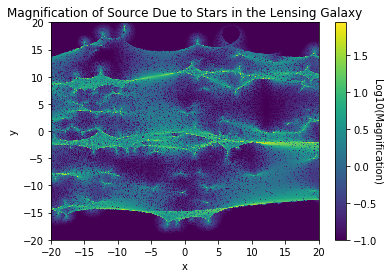

In [15]:
mags[mags>100] = 30
mags[mags<.1] = .1

ny, nx = 512, 512
xmin=-20
xmax=20
ymin=-20
ymax=20

# Generate a regular grid to interpolate the data.
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using delaunay triangularization 
zi = griddata((np.reshape(xst,(2560000)),np.reshape(yst,(2560000))),np.log10(np.reshape(mags,(2560000))),(xi,yi))

# Plot the results
plt.figure()
plt.pcolormesh(xi,yi,zi)
cbar = plt.colorbar()
plt.axis([xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Magnification of Source Due to Stars in the Lensing Galaxy')
cbar.set_label('Log10(Magnification)', rotation=270)
plt.show()

The magnification map is a convenient way for scientists to characterize the lens system, but it is not directly observable.  In a real world observation, the relative motion of the source and the lens will cause the source to traverse a line in the magnification map and the brightness of the image will change over time.  We can see what this might look like by sampling a slice of the magnification map. 

Text(0.5,1,'Example Light Curve')

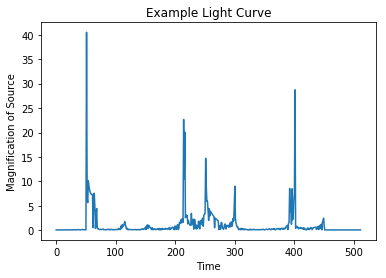

In [16]:
plt.clf()
plt.plot(10**zi[:, 256])
plt.xlabel('Time')
plt.ylabel('Magnification of Source')
plt.title('Example Light Curve')